In [1]:
# chatgpt-4o-latest (22/8/2024) : 

# Import necessary libraries
import os
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import timm
from timm.utils import accuracy, AverageMeter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
from datetime import datetime
import shutil

In [2]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom dataset folder
data_dir = r"C:\Users\RYZEN\RECC\classif_timm\RECC_IMAGES_SUM1-5-uncrop-classify-by-mon"  # Replace with your dataset folder path

# Preset parameters
dropout_rate = 0.3
learning_rate = 1e-4
num_epochs = 20
batch_size = 32
img_size = 224
split_ratio = 0.7

# Data Augmentation
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

# Load dataset and split into train and test sets
dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
num_classes = len(dataset.classes)
train_size = int(split_ratio * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
test_dataset.dataset.transform = test_transform  # Apply test transform for the test dataset

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model with transfer learning
model_name = 'vit_base_patch16_224'
model = timm.create_model(model_name, pretrained=True, num_classes=num_classes, drop_rate=dropout_rate)
model = model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Summary Information before training
print(f"Dataset Directory: {data_dir}")
print(f"Number of Classes: {num_classes} - {dataset.classes}")
print(f"Dropout Rate: {dropout_rate}")
print(f"Learning Rate: {learning_rate}")
print(f"Training/Test Split: {split_ratio * 100:.1f}% / {(1 - split_ratio) * 100:.1f}%")
print(f"Number of Training Images: {train_size}")
print(f"Number of Testing Images: {test_size}")
print(f"Number of Epochs: {num_epochs}")
print(f"Batch Size: {batch_size}")
print(f"Image Size: {img_size}x{img_size}")
print(f"Using Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

# Training Function
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    losses = AverageMeter()
    accs = AverageMeter()
    start_time = time.time()

    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        acc = accuracy(outputs, targets)[0]
        losses.update(loss.item(), images.size(0))
        accs.update(acc.item(), images.size(0))

    epoch_time = time.time() - start_time
    return losses.avg, accs.avg, epoch_time

# Evaluation Function
def validate_epoch(model, loader, criterion, device):
    model.eval()
    losses = AverageMeter()
    accs = AverageMeter()
    start_time = time.time()

    with torch.no_grad():
        for images, targets in loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            loss = criterion(outputs, targets)

            acc = accuracy(outputs, targets)[0]
            losses.update(loss.item(), images.size(0))
            accs.update(acc.item(), images.size(0))

    epoch_time = time.time() - start_time
    return losses.avg, accs.avg, epoch_time

Dataset Directory: C:\Users\RYZEN\RECC\classif_timm\RECC_IMAGES_SUM1-5-uncrop-classify-by-mon
Number of Classes: 3 - ['good', 'not_use', 'reject']
Dropout Rate: 0.3
Learning Rate: 0.0001
Training/Test Split: 70.0% / 30.0%
Number of Training Images: 1428
Number of Testing Images: 613
Number of Epochs: 20
Batch Size: 32
Image Size: 224x224
Using Device: GPU


In [3]:
# Training Loop
train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # Train and validate for one epoch
    train_loss, train_acc, train_time = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, val_time = validate_epoch(model, test_loader, criterion, device)

    # Store the results
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Print the results for this epoch
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Time: {train_time:.2f}s")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | Time: {val_time:.2f}s")

    # Estimate time remaining
    remaining_epochs = num_epochs - (epoch + 1)
    est_time_remaining = (train_time + val_time) * remaining_epochs
    print(f"Estimated Time Remaining: {time.strftime('%H:%M:%S', time.gmtime(est_time_remaining))}")




Epoch 1/20
Train Loss: 0.4516 | Train Acc: 88.38% | Time: 181.40s
Val Loss: 0.3860 | Val Acc: 88.09% | Time: 16.50s
Estimated Time Remaining: 01:02:40

Epoch 2/20
Train Loss: 0.3476 | Train Acc: 90.13% | Time: 174.81s
Val Loss: 0.4432 | Val Acc: 86.62% | Time: 13.00s
Estimated Time Remaining: 00:56:20

Epoch 3/20
Train Loss: 0.2595 | Train Acc: 92.44% | Time: 175.07s
Val Loss: 0.1743 | Val Acc: 93.96% | Time: 12.95s
Estimated Time Remaining: 00:53:16

Epoch 4/20
Train Loss: 0.2321 | Train Acc: 92.44% | Time: 174.94s
Val Loss: 0.2435 | Val Acc: 92.01% | Time: 12.63s
Estimated Time Remaining: 00:50:01

Epoch 5/20
Train Loss: 0.1513 | Train Acc: 95.03% | Time: 177.23s
Val Loss: 0.1270 | Val Acc: 95.43% | Time: 16.92s
Estimated Time Remaining: 00:48:32

Epoch 6/20
Train Loss: 0.1332 | Train Acc: 96.15% | Time: 181.74s
Val Loss: 0.3720 | Val Acc: 88.91% | Time: 13.05s
Estimated Time Remaining: 00:45:27

Epoch 7/20
Train Loss: 0.2082 | Train Acc: 94.26% | Time: 175.07s
Val Loss: 0.2798 | Va

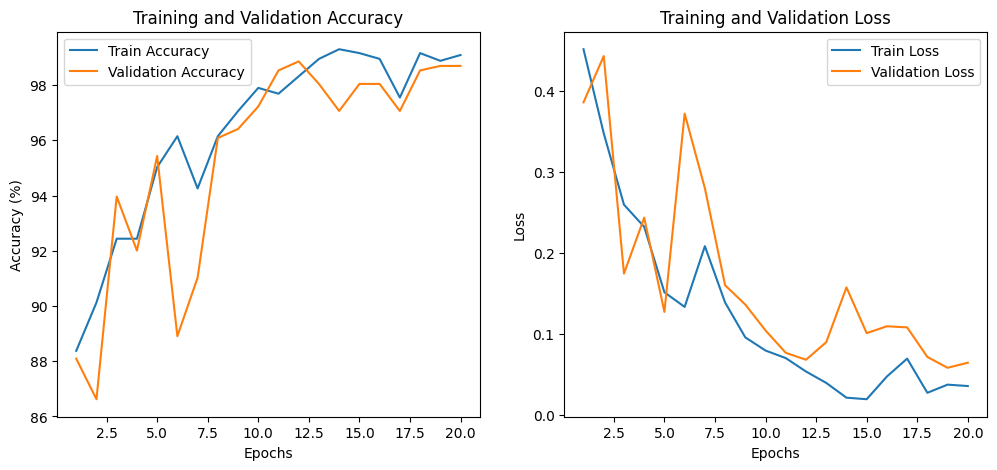

Model saved to C:\Users\RYZEN\RECC\classif_timm\RECC_IMAGES_SUM1-5-uncrop-classify-by-mon\vit_base_patch16_224_val_acc_98.69_time_20240822_104119.pth


In [9]:
# Plot Accuracy and Loss Trends
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accs, label='Train Accuracy')
plt.plot(epochs_range, val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

# Save the model
val_acc_last = val_accs[-1]
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f"{model_name}_val_acc_{val_acc_last:.2f}_time_{timestamp}.pth"
model_path = os.path.join(data_dir, model_filename)
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Inference and Display Misclassified Images with Heatmaps
from torchvision.utils import make_grid
import cv2
import matplotlib.cm as cm

def visualize_heatmap(image, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    heatmap = cv2.applyColorMap(heatmap, colormap)
    heatmap = heatmap / 255.0
    overlayed_image = image * (1 - alpha) + heatmap * alpha
    return np.clip(overlayed_image, 0, 1)




Number of Misclassified Images: 8


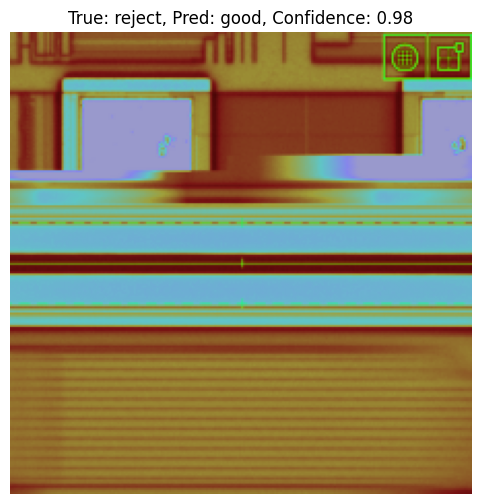

Filename: C:\Users\RYZEN\RECC\classif_timm\RECC_IMAGES_SUM1-5-uncrop-classify-by-mon\reject\D__RECC_IMG_TSWD293_11038_2024_Jul_20240722133124_6968034_True_17_Right-2_cropped.png



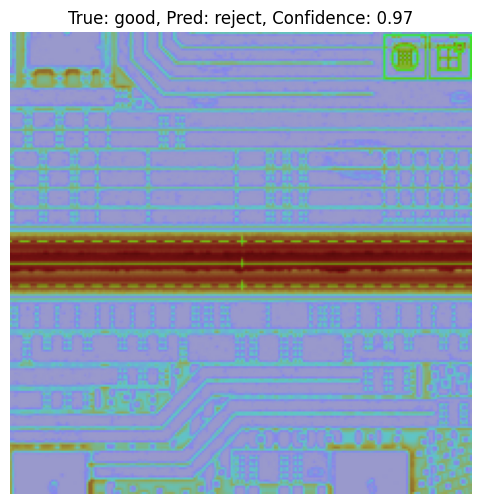

Filename: C:\Users\RYZEN\RECC\classif_timm\RECC_IMAGES_SUM1-5-uncrop-classify-by-mon\good\D__RECC_IMG_TSWD294_11042_2024_Jul_20240722074627_6955626_True_14_Left-1_cropped.png



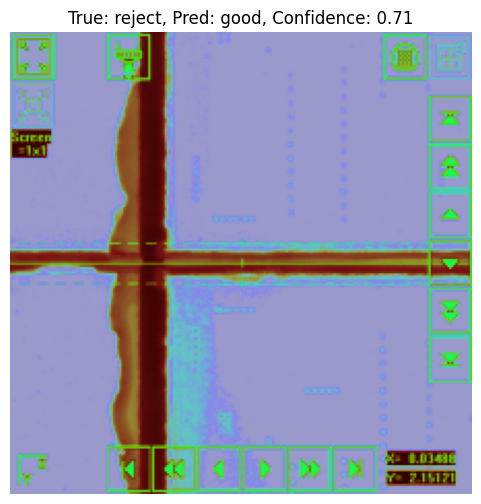

Filename: C:\Users\RYZEN\RECC\classif_timm\RECC_IMAGES_SUM1-5-uncrop-classify-by-mon\reject\D__RECC_IMG_TSWD294_11038_2024_Jul_20240724192810_7069535_True_14_Left-1_cropped.png



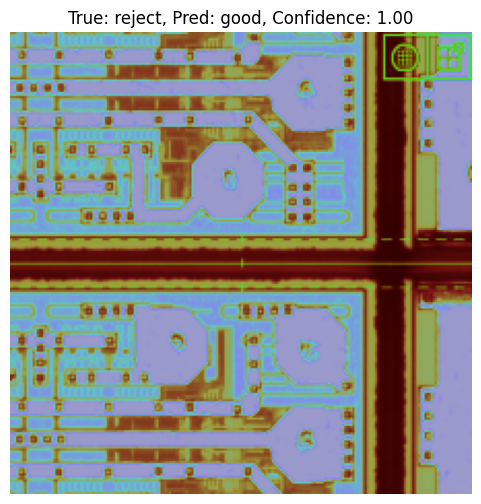

Filename: C:\Users\RYZEN\RECC\classif_timm\RECC_IMAGES_SUM1-5-uncrop-classify-by-mon\reject\D__RECC_IMG_TSWD293_11042_2024_Jul_20240718221538_6808600_True_7_Right-1_cropped.png



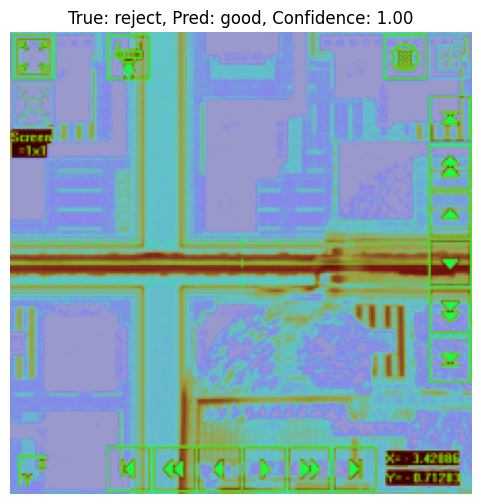

Filename: C:\Users\RYZEN\RECC\classif_timm\RECC_IMAGES_SUM1-5-uncrop-classify-by-mon\reject\D__RECC_IMG_TSWD294_11038_2024_Jul_20240724220338_7073667_True_17_Right-2_cropped.png



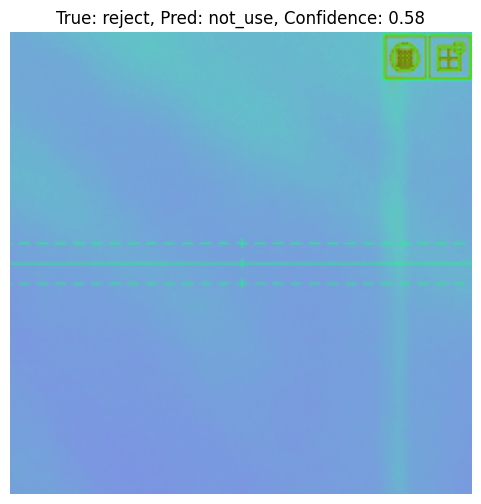

Filename: C:\Users\RYZEN\RECC\classif_timm\RECC_IMAGES_SUM1-5-uncrop-classify-by-mon\reject\D__RECC_IMG_TSWD294_11038_2024_Jul_20240725094634_7092292_True_6_Left-2_cropped.png



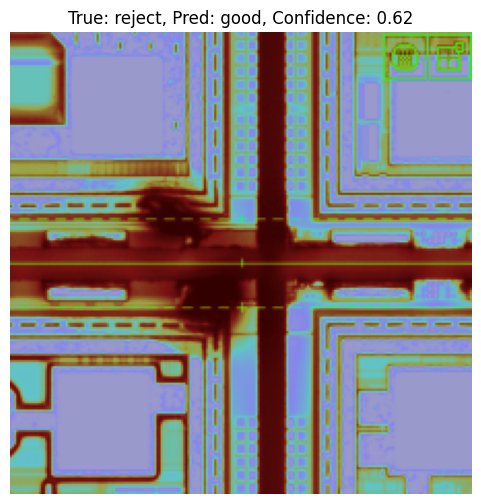

Filename: C:\Users\RYZEN\RECC\classif_timm\RECC_IMAGES_SUM1-5-uncrop-classify-by-mon\reject\D__RECC_IMG_TSWD294_11042_2024_Jul_20240711152732_6464497_True_12_Right-2_cropped.png



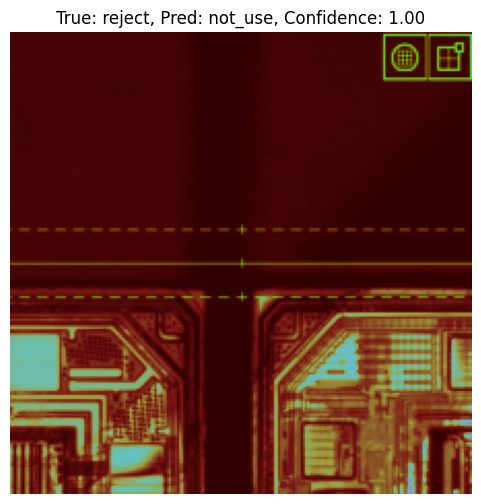

Filename: C:\Users\RYZEN\RECC\classif_timm\RECC_IMAGES_SUM1-5-uncrop-classify-by-mon\reject\D__RECC_IMG_TSWD293_11038_2024_Jul_20240712152827_6501971_True_21_Right-2_cropped.png



In [10]:
import torch.nn.functional as F

def show_misclassified_images(model, loader, device):
    model.eval()
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []
    misclassified_filenames = []
    misclassified_confidences = []

    with torch.no_grad():
        for idx, (images, targets) in enumerate(loader):
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)  # Convert logits to probabilities
            _, preds = torch.max(outputs, 1)

            misclassified_idx = (preds != targets).nonzero(as_tuple=True)[0]
            for i in misclassified_idx:
                misclassified_images.append(images[i])
                misclassified_labels.append(targets[i])
                misclassified_preds.append(preds[i])
                misclassified_confidences.append(probs[i][preds[i]].item())  # Store confidence level

                # Get the original index from the Subset, then find the filename
                original_idx = loader.dataset.indices[idx * batch_size + i]
                filename = loader.dataset.dataset.samples[original_idx][0]
                misclassified_filenames.append(filename)

    # Display misclassified images with heatmaps and confidence levels
    num_misclassified = len(misclassified_images)
    if num_misclassified > 0:
        print(f"\nNumber of Misclassified Images: {num_misclassified}")
        for i in range(min(num_misclassified, 10)):  # Display up to 10 misclassified images
            img = misclassified_images[i].cpu().numpy().transpose(1, 2, 0)
            img = np.clip(img, 0, 1)
            pred_label = dataset.classes[misclassified_preds[i].item()]
            true_label = dataset.classes[misclassified_labels[i].item()]
            confidence = misclassified_confidences[i]
            filename = misclassified_filenames[i]

            # Generate heatmap (using a simple grayscale overlay here)
            heatmap = cv2.cvtColor(cv2.resize(img, (224, 224)), cv2.COLOR_RGB2GRAY)
            heatmap = np.uint8(255 * heatmap)
            overlayed_image = visualize_heatmap(img, heatmap)

            # Plot image and heatmap
            plt.figure(figsize=(6, 6))
            plt.imshow(overlayed_image)
            plt.title(f"True: {true_label}, Pred: {pred_label}, Confidence: {confidence:.2f}")
            plt.axis('off')
            plt.show()
            print(f"Filename: {filename}\n")

    else:
        print("\nNo misclassified images found.")

# Run inference and display misclassified images with confidence levels
show_misclassified_images(model, test_loader, device)